GAMEPLAN:
- Run FVA on SQS+SQE+MVA 'c' and show no flux
- Isolate each alternative pathway individually by knocking out the downstream connection, and see how much flux being carried from each. Graph
- Conclude that MVA doesn't receive flux and find mechanism that causes this
- Run final experiment to confirm

### Setup

In [1]:
import os, sys
sys.path.append('..')

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='cobra')

from cobra import io, Model, Solution
from scripts.helpers.model import rxn_in_model, met_in_model, add_single_gene_reaction_pair
from scripts.opt._fba import flux_balance_analysis
from scripts.opt._fva import run_flux_variability_analysis

Our strategy is to incorporate the MVA pathway in the cytosol. However to test if MVA inactivity is a flux issue, we've also made an additional alteration which places the MVA pathway in the chloroplast, and defines necessary transfer reactions for the precursors. Our very first step is to introduce the ergosterol exchange reactions to support flux to ergosterol in both models.

In [3]:
params = {
    'mode': 'auto' # Also 'hetero' or 'mixo'
}

# Gap-filled models
model_mva_c = io.read_sbml_model(f'../data/altered/xmls/MNL_iCre1355_{params['mode']}_GAPFILL/SQS+SQE+MVA.xml')
model_mva_h = io.read_sbml_model(f'../data/altered/xmls/MNL_iCre1355_{params['mode']}_GAPFILL/h/SQS+SQE+MVA.xml')

# Add exchange reaction
ERG = "ergosterol_c"
ERGEXCH = "ERGOSTEROLEXCH"
if not rxn_in_model(model_mva_c, ERGEXCH):
    add_single_gene_reaction_pair(
        model=model_mva_c, 
        gene_id="EXCHERG_GENE",
        reaction_id=ERGEXCH,
        reaction_name="Ergosterol exchange (assumption)", 
        reaction_subsystem="Exchange", 
        metabolites=[(-1, ERG)],
        reversible=True
    )

if not rxn_in_model(model_mva_h, ERGEXCH):
    add_single_gene_reaction_pair(
        model=model_mva_h,
        gene_id="EXCHERG_GENE",
        reaction_id=ERGEXCH,
        reaction_name="Ergosterol exchange (assumption)",
        reaction_subsystem="Exchange",
        metabolites=[(-1, ERG)],
        reversible=True
    )

No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized


### FVA (Blocked)

In [7]:
fva_c = run_flux_variability_analysis(
    model_mva_c,
    loopless=True,
    pfba_factor=None,
    objectives=[ERGEXCH],
    reactions=['ALT_MVAS', 'ALT_MVAD', 'ALT_MVAE', 'ALT_PMK', 'ALT_MVK', 'ALT_IDLI']
)

fva_h = run_flux_variability_analysis(
    model_mva_h,
    loopless=True,
    pfba_factor=None,
    objectives=[ERGEXCH],
    reactions=['ALT_MVAS', 'ALT_MVAD', 'ALT_MVAE', 'ALT_PMK', 'ALT_MVK', 'ALT_IDLI']
)

print(f"Minimum flux for Cytosolic MVA: {fva_c.loc['ALT_MVAD', 'minimum']:.6f} | Maximum: {fva_c.loc['ALT_MVAD', 'maximum']:.6f}")
print(f"Minimum flux for Chloroplast MVA: {fva_h.loc['ALT_MVAD', 'minimum']:.6f} | Maximum: {fva_h.loc['ALT_MVAD', 'maximum']:.6f}")

# Display full FVA results
# print("\nFull FVA Results - Cytosolic MVA:")
# print(fva_c)
# print("\nFull FVA Results - Chloroplast MVA:")
# print(fva_h)

Minimum flux for Cytosolic MVA: 0.000000 | Maximum: 0.000000
Minimum flux for Chloroplast MVA: 0.000000 | Maximum: 0.000000


Upon realizing that MVA is not able to receive flux in both models, we've decided to study the knockout on both models and observe how much flux each competitive pathway can support. This leads us to the next experiment

### FVA (Knock-out)

Following the previous results, we isolate each competing pathway and MVA to see how much flux they can support when optimized for ergosterol. This will show us if flux through MVA is a model issue or is the final result.

MEP pathway can be connected to the sterol synthesis pathway through 3 exchange reactions: FRDPth, GRDPth, and IPDPth. All of these are post-MEP, and the only difference is where the sequence of reactions Geranyl Diphosphate Synthase and Farnesyl Diphosphate Synthase would take place (both can happen in either chloroplast or cytosol).

In [ ]:
def format_name(name: str):
    
    if name == ERGEXCH: return "ERGEXCH"
    return "PATH/RXN"



def fba_knockout(m: Model, chloroplast: bool):
    """
    Perform flux balance analysis (FBA) knockout simulations.
    """

    # Save path for temporary model constructs for fluxer analysis
    save_path = os.path.join('.', 'temp', 'mva')
    os.makedirs(save_path, exist_ok=True)

    # Isolation strategy
    knockouts_res = {} # Results
    alt = ['FRDPth', 'IPDPth', 'GRDPth', 'ALT_MVAD'] # Cut-off reactions of competitive pathways
    if chloroplast:
        alt = ['CMK', 'ALT_MVAD']

    for rid in alt:

        temp = m.copy()

        for other in alt:
            if other == rid: continue
            rxn = temp.reactions.get_by_id(other)
            rxn.lower_bound = 0
            rxn.upper_bound = 0

        fva = run_flux_variability_analysis(
            temp,
            loopless=True,
            pfba_factor=None,
            objectives=[ERGEXCH],
            reactions=[
                # 'ALT_MVAS',
                # 'ALT_MVAD',
                # 'ALT_MVAE',
                # 'ALT_PMK',
                # 'ALT_MVK',
                # 'ALT_IDLI',
                # 'GPPS',
                # 'FPPS',
                # 'SS',
                # 'ALT_SQS2',
                'Biomass_Chlamy_auto',
                ERGEXCH
            ] + alt
        )

        io.write_sbml_model(temp, os.path.join(save_path, 'temp.xml'))

        knockouts_res[rid] = fva.loc[[rid,ERGEXCH],'maximum'].rename(index=format_name)

    return knockouts_res

res_c = fba_knockout(model_mva_c, chloroplast=False)
res_h = fba_knockout(model_mva_h, chloroplast=True)

results = {
    'FRDPth': res_c['FRDPth'],
    'IPDPth': res_c['IPDPth'],
    'GRDPth': res_c['GRDPth'],
    'MVA (Cytosolic)': res_c['ALT_MVAD'],
    'MVA (Chloroplast)': res_h['ALT_MVAD']
}

Creating heatmaps for cytosolic and chloroplast MVA results...


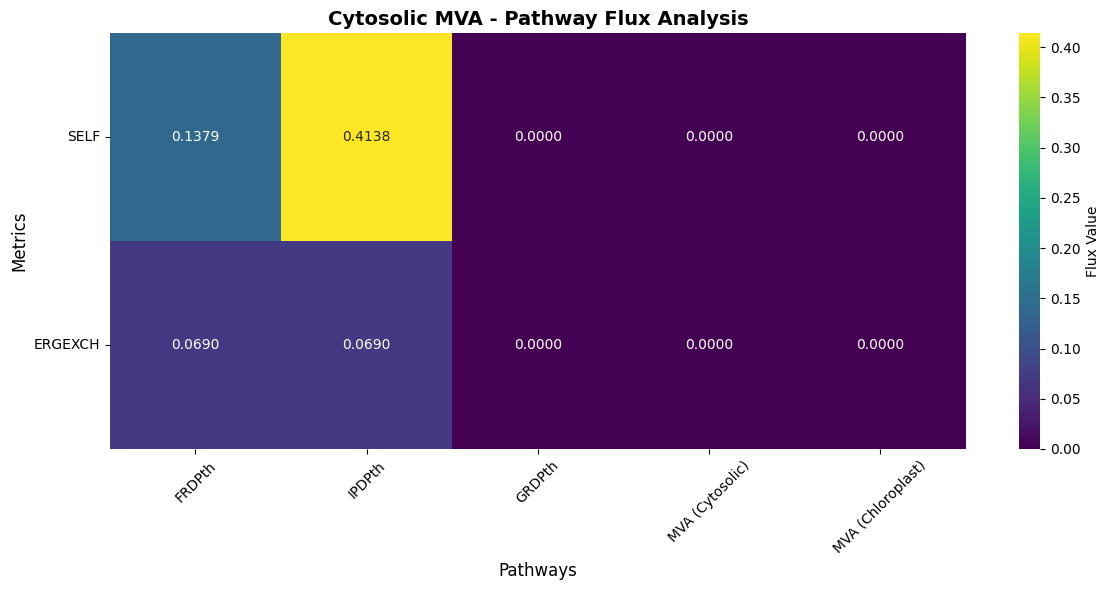

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def create_result_heatmap(result_dict, title="Heatmap", figsize=(10, 6), cmap='viridis', annot=True):
    """
    Create a heatmap visualization from a result object with keys as columns
    and Series values (with 2 values each) as rows.
    
    Parameters:
    -----------
    result_dict : dict
        Dictionary where keys become columns and values are pd.Series with 2 values
    title : str
        Title for the heatmap
    figsize : tuple
        Figure size (width, height)
    cmap : str
        Colormap for the heatmap
    annot : bool
        Whether to annotate cells with values
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """

    # Convert result dictionary to DataFrame
    data_matrix = []
    column_names = list(result_dict.keys())
    
    # Get the index names from the first Series (assuming all have same structure)
    first_series = list(result_dict.values())[0]
    row_names = first_series.index.tolist()
    
    # Build the data matrix
    for col_name in column_names:
        series_data = result_dict[col_name]
        data_matrix.append(series_data.values)
    
    # Transpose to get proper orientation (rows = series indices, columns = dict keys)
    data_matrix = np.array(data_matrix).T
    
    # Create DataFrame for easier handling
    df = pd.DataFrame(data_matrix, index=row_names, columns=column_names)
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.heatmap(df, 
                annot=annot, 
                cmap=cmap, 
                fmt='.4f',
                cbar_kws={'label': 'Flux Value'},
                ax=ax)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Pathways', fontsize=12)
    ax.set_ylabel('Metrics', fontsize=12)
    
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    return fig, ax

# Example usage with your result objects:
print("Creating heatmaps for cytosolic and chloroplast MVA results...")

# Define save path
save_path = os.path.join('..','results','bench','mva')
os.makedirs(save_path, exist_ok=True)
# Create heatmap for cytosolic results
fig, ax = create_result_heatmap(results, 
                                    title="Cytosolic MVA - Pathway Flux Analysis", 
                                    figsize=(12, 6))
# Save the figure
fig.savefig(os.path.join(save_path, "cytosolic_mva_heatmap.png"), dpi=300)
# Show
plt.show()

The above heatmap confirms that despite being isolated, MVA cannot activate and prodoce the precursors essential to ergosterol. Inclined to think this is not a model issue, as upstreeam and downstream of MVA there's flux, we've investigated the mechanism that may cause this behaviour. We've looked into the flow of flux for the precursors of MVA and studied what mechanisms they bind to.

### FVA (Repaired)

In [5]:
temp = model.copy()

# Acetyl_CoA_c = temp.metabolites.get_by_id("accoa_c")
# Acetyl_CoA_h = temp.metabolites.get_by_id("accoa_h")

FPPS = temp.reactions.get_by_id('FPPS')
mets = FPPS.metabolites

add_single_gene_reaction_pair(
    model=temp,
    gene_id="FPPS_ATTEMPT",
    reaction_id='FPPS_NEW',
    reaction_name="Farnesyl pyrophosphate synthase (manual)",
    reaction_subsystem="Biosynthesis of steroids",
    metabolites=[ (k, v.id) for v, k in mets.items() ],
    reversible=False
)

FPPS.lower_bound = 0
FPPS.upper_bound = 0

fva = run_flux_variability_analysis(
    model=temp,
    loopless=True,
    pfba_factor=None,
    objectives=['ALT_MVAS'],
    reactions=['ALT_MVAS', 'ALT_MVAD', 'ALT_MVAE', 'ALT_PMK', 'ALT_MVK', 'ALT_IDLI']
)

fva

,minimum,maximum
ALT_MVAS,0.0,-5.349016e-31
ALT_MVAD,0.0,0.000000e+00
ALT_MVAE,0.0,-5.349016e-31
ALT_PMK,0.0,0.000000e+00
ALT_MVK,0.0,-2.790923e-29
ALT_IDLI,0.0,1.379310e-01
